In [1]:
# External packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime 


# Internal packages
import sys
sys.path.append('../../Time_Series_Forecasting/TS_helpers/')
from dates_kaggle1min import make_all_time_indexes, make_integer_time_index

In [2]:
data = pd.read_csv('../../Data/Coins/BTC_USD/bitcoin-historical-data/wdi_bitstampUSD_1-min_data_2012-01-01_to_2019-03-13.csv')
print(data.shape)
data.head()

(3778817, 20)


,Timestamp,time_exchange,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,year,month,day,hour,minute,time_year,time_month,time_day,time_hour,time_minute,date
0,1325317920,2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011,12,31,7,52,2011,201112,20111231,2011123107,201112310752,2011-12-31
1,1325317980,2011-12-31 07:53:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,12,31,7,53,2011,201112,20111231,2011123107,201112310753,2011-12-31
2,1325318040,2011-12-31 07:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,12,31,7,54,2011,201112,20111231,2011123107,201112310754,2011-12-31
3,1325318100,2011-12-31 07:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,12,31,7,55,2011,201112,20111231,2011123107,201112310755,2011-12-31
4,1325318160,2011-12-31 07:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,12,31,7,56,2011,201112,20111231,2011123107,201112310756,2011-12-31


In [3]:
# data['time_exchange'] = data['Timestamp'].apply(lambda x : datetime.datetime.utcfromtimestamp(int(x))).astype(str)
# data.set_index('time_exchange', inplace=True)
# data = make_all_time_indexes(data.reset_index())

In [4]:
# data.set_index('Timestamp').to_csv('../../Data/Coins/BTC_USD/bitcoin-historical-data/wdi_bitstampUSD_1-min_data_2012-01-01_to_2019-03-13.csv')

In [5]:
# get date from unix timestamp
data['time_exchange'] = data['Timestamp'].apply(lambda x : datetime.datetime.utcfromtimestamp(int(x)))
# make the time indexes as standard
# data = make_all_time_indexes(data)

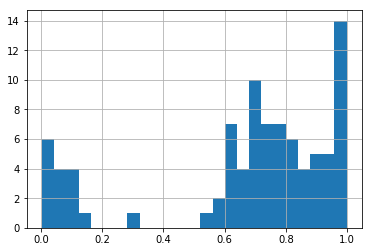

In [6]:
data.groupby('time_month')['Weighted_Price'].agg(lambda x: sum(pd.notna(x))/len(x) ).hist(bins=25)

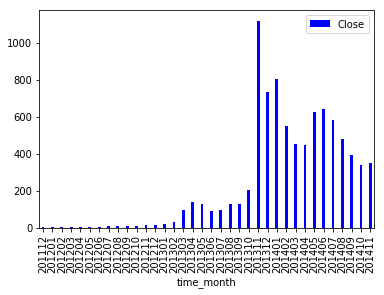

In [7]:
data[:1500000].groupby('time_month')[['Close']].agg(lambda x: [a for a in list(x) if not np.isnan(a)][-1]).plot.bar(color='b', width=0.3)

In [ ]:
data['Weighted_Price']

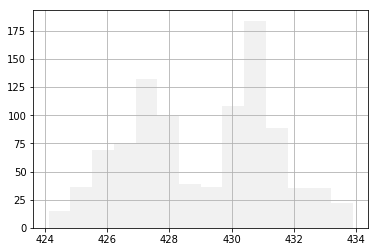

In [105]:
from matplotlib.colors import Colormap as cmap
from matplotlib import pyplot as plt
import matplotlib as mtplt
cmap = mtplt.cm.get_cmap('Greys')

steps=30
cmap = cmap(steps)
first = 20160101
for s in range(steps):
    data[(data['time_day']==first+k) ]['Weighted_Price'].hist(bins=int(data[(data['time_day']==first+k)].shape[0]/100),
                                                              color=cmap)


In [94]:
mtplt.cm.Greys(1)

(0.9981545559400231, 0.9981545559400231, 0.9981545559400231, 1.0)

In [18]:
data.index.nunique() == data.shape[0]

True

In [123]:
# Daily time series

data['Weighted_PriceXVol'] = data['Weighted_Price'] * data['Volume_(Currency)']
daily_weighted_price = data.groupby('time_month')['Weighted_PriceXVol'].sum()/(data.groupby('time_month')['Volume_(Currency)'].sum())
daily_max = data.groupby('time_day')['High'].max()


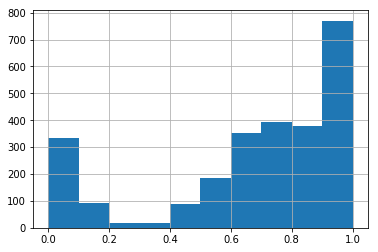

In [97]:
data.groupby('time_day')[['Close', 'Open']].agg(lambda x : sum(pd.notna(x))/len(x) ).hist()

In [2]:
import pandas as pd
df_trade = pd.read_csv('../../Data/Coins/BTC_USD/Trade_Data/BITSTAMP_TRADE_SPOTBTC_cum.csv' , index_col='time_exchange')

In [10]:
import matplotlib.pyplot as plt

m, k=0, 1200
volume= data.groupby('date')['Volume_(BTC)'].sum()[m:k]
count= data.groupby('date')['Volume_(BTC)'].mean()[m:k]
price=data.groupby('date')['Weighted_Price'].mean()[m:k]
returns =((data.groupby('date')['Close'].mean())/data.groupby('date')['Close'].mean().shift())[m:k]
returns_keep_and_hold =((data.groupby('date')['Close'].mean())/data.groupby('date')['Close'].mean()[0])[m:k]




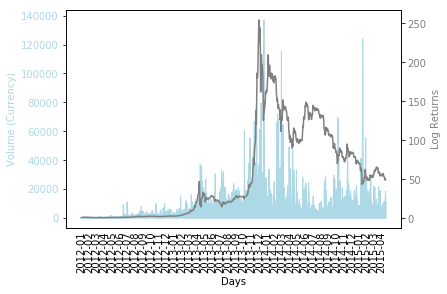

In [14]:
fig, ax1 = plt.subplots()

# Create some mock data
t = volume.index
data1 = volume.values
data2 = (returns_keep_and_hold.values)

ax1.set_xlabel('Days')
ax1.set_ylabel('Volume (Currency)', color='lightblue')
ax1.fill_between(t, 0, data1, color='lightblue' )
ax1.tick_params(axis='y', labelcolor='lightblue')
ax1.tick_params(axis='x', rotation=90, size=0.01)
# ax1.set_ylim(0, 500)

ax2 = ax1.twinx()


ax2.set_ylabel('Log Returns', color='grey')  # we already handled the x-label with ax1
ax2.plot(t, data2, color='grey')
ax2.tick_params(axis='y', labelcolor='grey')
# ax2.set_ylim(0, 2)


plt.xticks([x for x in volume.index if str(x)[-2:]=='01'], 
           [str(x)[:7] for x in volume.index if str(x)[-2:]=='01'])

# fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [15]:
import pandas as pd
import numpy as np

import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms

import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

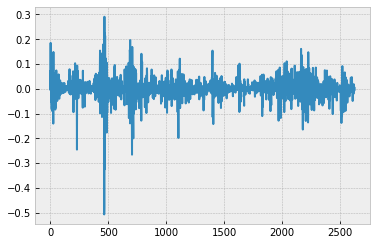

In [54]:
with plt.style.context('bmh'):
    plt.plot(lrets)

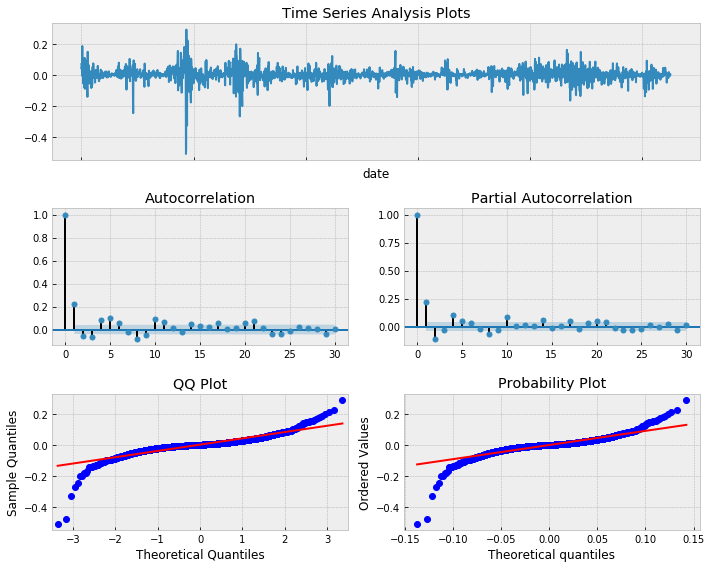

In [23]:


tsplot(((data.groupby('date')['Close'].mean())/data.groupby('date')['Close'].mean().shift()).dropna().apply(np.log)[:5000], 30)



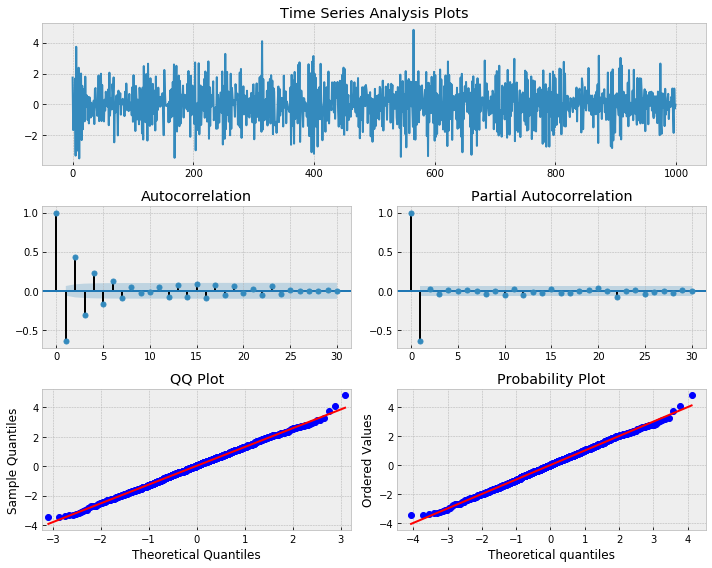

In [24]:

np.random.seed(1)
n_samples = int(1000)
a = -0.6
x = w = np.random.normal(size=n_samples)
vals  =((data.groupby('date')['Volume_(BTC)'].mean())/data.groupby('date')['Volume_(BTC)'].mean().shift()).apply(np.log).values
for t in range(n_samples):
    x[t] = a*x[t-1]+w[t]

    
_ = tsplot(x, lags=30)


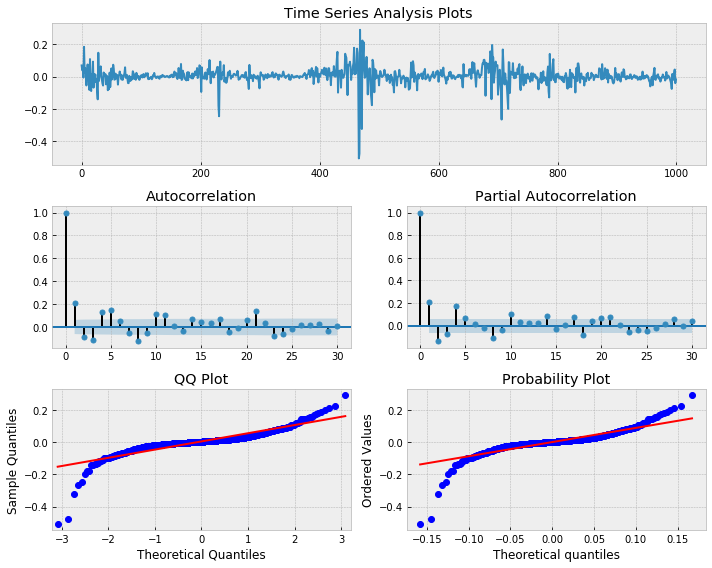

In [25]:

np.random.seed(1)
n_samples = int(1000)
a = 0
x = ((data.groupby('date')['Close'].mean())/data.groupby('date')['Close'].mean().shift()).dropna().apply(np.log).values[:1000]
    
_ = tsplot(x, lags=30)


In [26]:
lrets = ((data.groupby('date')['Close'].mean())/data.groupby('date')['Close'].mean().shift()).dropna().apply(np.log).values

In [31]:
# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(lrets[:20000],
                      order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: %6.2f | order: %s'%(best_aic, best_order))

aic: -9604.91 | order: (4, 3)


<BarContainer object of 50 artists>

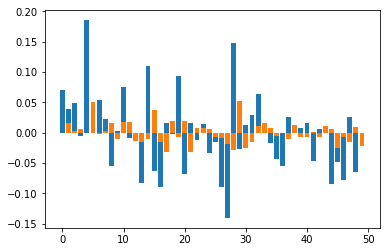

In [50]:
steps = 50

plt.bar(list(range(len(lrets[:steps]))), lrets[:steps])
plt.bar(list(range(len(lrets[:steps]))), best_mdl.predict()[:steps])
# best_mdl.predict()

In [48]:
best_mdl.params

array([ 0.28717279,  0.04680372, -0.60382837,  0.24217719, -0.05001554,
       -0.14736548,  0.53564295])

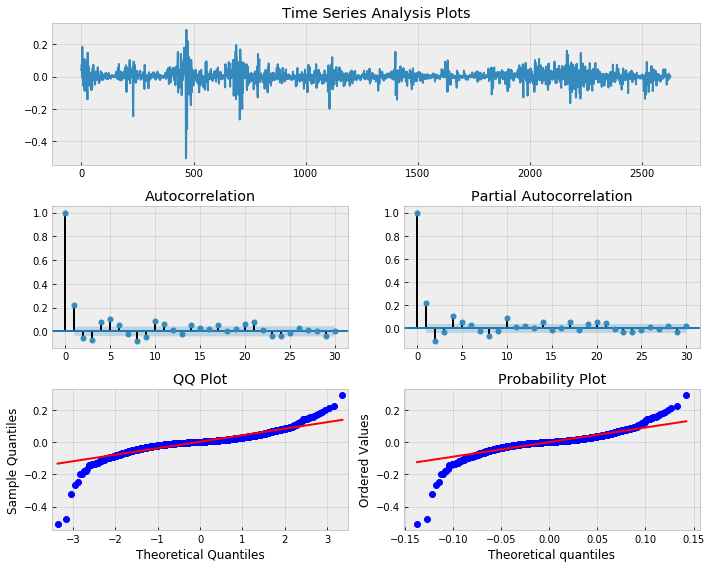

In [32]:
_ = tsplot(lrets[:20000], lags=30)

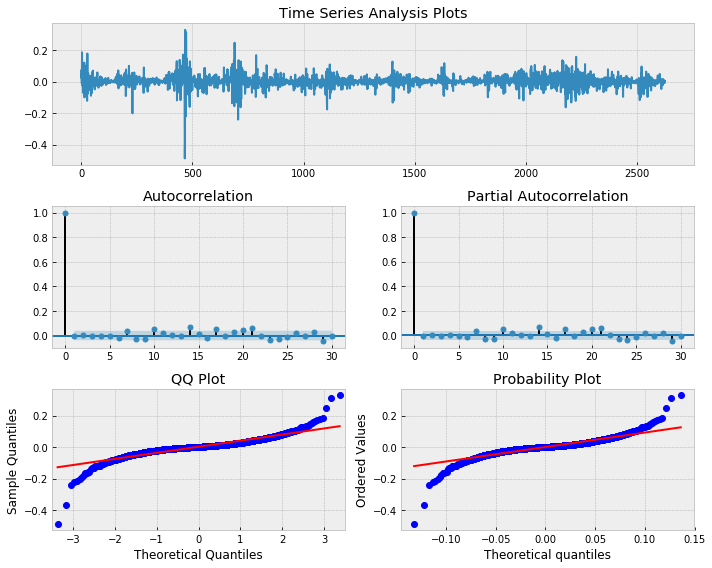

In [34]:
_ = tsplot(best_mdl.resid, lags=30)
# from statsmodels.stats.stattools import jarque_bera

# score, pvalue, _, _ = jarque_bera(mdl.resid)

# if pvalue < 0.10:
#     print(The residuals may not be normally distributed.')
# else:
#     print 'The residuals seem normally distributed.'

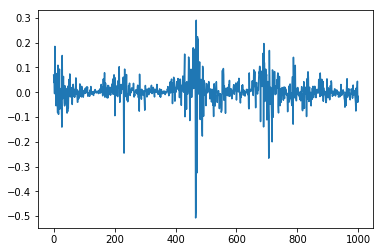

In [113]:
plt.plot(lrets[:1000])

In [ ]:
# Fit ARIMA(p, d, q) model to SPX log returns
# pick best order and final model based on aic

best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(lrets[:2000], 
                          order=(i,d,j)).fit(method='mle',
                          trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.2f} | order: {}'.format(best_aic, best_order))

# ARIMA model resid plot
_ = tsplot(best_mdl.resid, lags=30)

In [123]:
sms.diagnostic.acorr_ljungbox(best_mdl.resid, lags=[20], boxpierce=False)

(array([38.25767838]), array([0.008235]))